# Argo Sample Rate

This notebook will investigate the sample rate of argo floats and how to account for this while loading boxes, interpolating to a standard pressure grid, and performing analysis. This is important to resolve because some (many?) profiles seem to have sampling rates of >100m, which would greatly interfere with the accuracy of filtering analysis, particularly at small scales. See this issue for more specific thoughts on how to address this: https://github.com/ocean-transport/argo-intern/issues/12#issuecomment-1655683014

In [1]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from cmocean import cm as cmo
import xrft
import pandas as pd


import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf
import MLD_funcs as mf

In [2]:
reload(df)
reload(ef)
reload(ff)
reload(pf)
reload(mf)

<module 'MLD_funcs' from '/home.ufs/amf2288/argo-intern/MLD_funcs.py'>

In [3]:
from argopy import DataFetcher as ArgoDataFetcher
argo_loader=ArgoDataFetcher(src='gdac',ftp="/swot/SUM05/dbalwada/Argo_sync",parallel=True,progress=True)

ds = argo_loader.region([-10,0,-40,-30,0,2000])
print('loading points complete')
ds = ds.to_xarray()
print('to xarray complete')
ds = ds.argo.point2profile()
print('point to profile complete')

loading points complete
to xarray complete
point to profile complete


In [11]:
depth_min, depth_max = 0, 2000
rate = 4

median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
ind_rate=median_dp.where(median_dp<rate,drop=True).N_PROF
ds_sel=ds.sel(N_PROF=ind_rate)

ds_rate = ds_sel.PRES.diff('N_LEVELS').sortby('N_PROF')

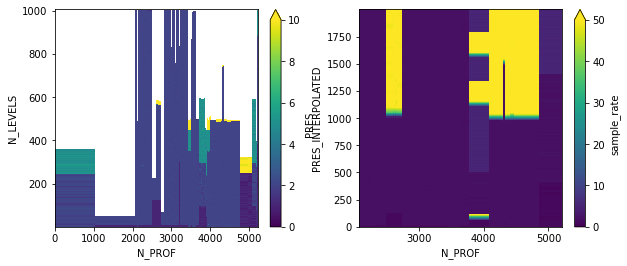

In [18]:
plt.figure(figsize=(10,4))

plt.subplot(121)
ds_rate.plot(x='N_PROF',y='N_LEVELS',vmin=0,vmax=10)
plt.subplot(122)
ds_interp.sample_rate.plot(x='N_PROF',y='PRES_INTERPOLATED',vmin=0,vmax=50)

In [13]:
ds['sample_rate'] = ds_rate
ds_interp = ff.get_ds_interp(ds,0,2000,4)

In [14]:
ds_interp

<xarray.Dataset>
Dimensions:                (N_PROF: 913, PRES_INTERPOLATED: 1000)
Coordinates:
  * N_PROF                 (N_PROF) int64 2075 2076 2077 2079 ... 5205 5206 5207
    TIME                   (N_PROF) datetime64[ns] 2013-09-24T23:32:09 ... 20...
    LATITUDE               (N_PROF) float64 -36.77 -36.97 ... -32.35 -34.72
    LONGITUDE              (N_PROF) float64 -8.853 -8.354 ... -9.948 -9.954
  * PRES_INTERPOLATED      (PRES_INTERPOLATED) int64 0 2 4 6 ... 1994 1996 1998
    N_PROF_NEW             (N_PROF) int64 0 1 2 3 4 5 ... 908 909 910 911 912
Data variables:
    CONFIG_MISSION_NUMBER  (N_PROF) int32 4 4 4 4 4 4 4 4 ... 55 56 58 2 2 2 3
    CYCLE_NUMBER           (N_PROF) int32 5 6 7 9 10 11 12 ... 55 56 58 4 8 9 19
    DATA_MODE              (N_PROF) <U1 'D' 'D' 'D' 'D' 'D' ... 'R' 'R' 'R' 'R'
    DIRECTION              (N_PROF) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_PROF) int32 1901657 1901657 ... 6902993 6902993
    PRES                   (N_PROF, PRES_INTERPOLATED) float32 1.1 ... 1.998e+03
    PSAL                   (N_PROF, PRES_INTERPOLATED) float32 34.98 ... 34.75
    TEMP                   (N_PROF, PRES_INTERPOLATED) float32 13.05 ... 2.803
    sample_rate            (N_PROF, PRES_INTERPOLATED) float32 0.8 ... 5.294
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         /swot/SUM05/dbalwada/Argo_sync
    Fetched_by:           amf2288
    Fetched_date:         2023/07/28
    Fetched_constraints:  [x=-10.00/0.00; y=-40.00/-30.00; z=0.0/2000.0]
    Fetched_uri:          /swot/SUM05/dbalwada/Argo_sync/dac/bodc/1901269/190...
    history:              Variables filtered according to DATA_MODE; Variable...

IndexError: index 1400 is out of bounds for axis 0 with size 913

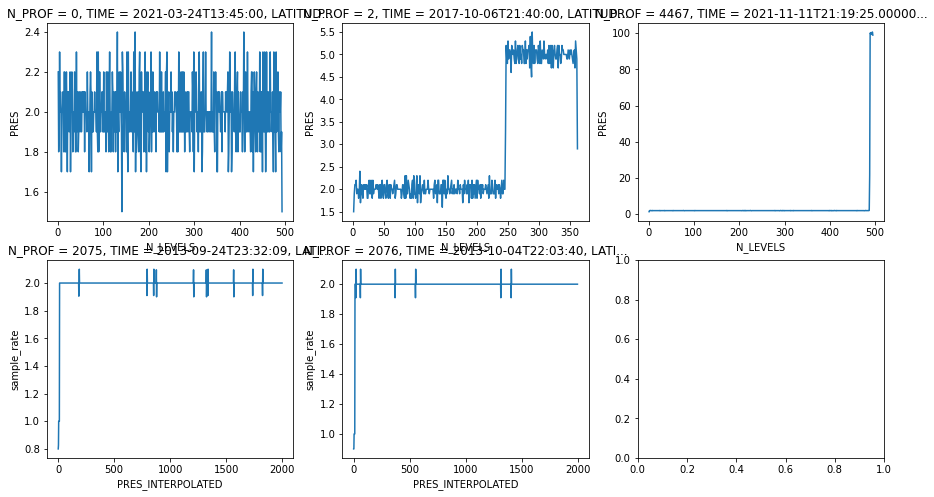

In [25]:
plt.figure(figsize=(15,8))

plt.subplot(2,3,1)
ds_rate.isel(N_PROF=0).plot()

plt.subplot(2,3,2)
ds_rate.isel(N_PROF=1).plot()

plt.subplot(2,3,3)
ds_rate.isel(N_PROF=1400).plot()

plt.subplot(2,3,4)
ds_interp.sample_rate.isel(N_PROF=0).plot()

plt.subplot(2,3,5)
ds_interp.sample_rate.isel(N_PROF=1).plot()

plt.subplot(2,3,6)
ds_interp.sample_rate.isel(N_PROF=1400).plot()